# One Class Support Vector Machines

## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [6]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")
classifier_tree = DecisionTreeClassifier()
train_end = 4320
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) #+shift
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time 

        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        count_false_neg = np.count_nonzero(boolean[train_end:infection_time])

        # Calculating the amount of true positives (infection time)
        count_true_pos = np.count_nonzero(boolean[infection_time:]) 

        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
    
    
    ##################################################################
    
   

Found 'CC006-315' and its infection value is '10300'
Minimum Score:  267.52007264767286
After Training Min:  11043
After Infection Min:  11043
First anomaly found after training: 6723 minutes with score 267.4976407369712
First anomaly found after infection: 743 minutes with score 267.4976407369712
True Positve Rate: 100.0%
Found 'CC006-316' and its infection value is '10300'
Minimum Score:  274.82851288077353
After Training Min:  6949
After Infection Min:  10462
First anomaly found after training: 2629 minutes with score 271.684894294429
First anomaly found after infection: 162 minutes with score 268.1715669032109
True Positve Rate: 98.08883112911857%
Found 'CC006-317' and its infection value is '10300'
Minimum Score:  293.83288135042164
After Training Min:  6702
After Infection Min:  12666
First anomaly found after training: 2382 minutes with score 271.149233897299
First anomaly found after infection: 2366 minutes with score 263.58820191686965
True Positve Rate: 99.80148455031936%
Fou

N/A
Found 'CC036-299' and its infection value is '10250'
Minimum Score:  323.19474810136023
After Training Min:  5303
After Infection Min:  10337
First anomaly found after training: 983 minutes with score 304.426578995666
First anomaly found after infection: 87 minutes with score 311.3600906587017
True Positve Rate: 97.50237663123326%
No match found for mouse 'B6-100'
No match found for mouse 'B6-101'
Found 'CC002-557' and its infection value is '14200'
Minimum Score:  154.95117991187385
After Training Min:  16166
After Infection Min:  16166
First anomaly found after training: 11846 minutes with score 148.2246177425813
First anomaly found after infection: 1966 minutes with score 148.2246177425813
True Positve Rate: 100.0%
Found 'CC002-558' and its infection value is '14200'
Minimum Score:  210.74568174220337
After Training Min:  6397
After Infection Min:  14559
First anomaly found after training: 2077 minutes with score 206.70493572999246
First anomaly found after infection: 359 minute

Minimum Score:  256.87083979617154
After Training Min:  13735
After Infection Min:  13735
First anomaly found after training: 9415 minutes with score 254.30563710000266
First anomaly found after infection: 2435 minutes with score 254.30563710000266
True Positve Rate: 100.0%
Found 'CC013-673' and its infection value is '11300'
Minimum Score:  333.5919668398689
After Training Min:  6832
After Infection Min:  11685
First anomaly found after training: 2512 minutes with score 312.2647421124288
First anomaly found after infection: 385 minutes with score 323.8356306061857
True Positve Rate: 99.51941560938101%
Found 'CC015-439' and its infection value is '11300'
Minimum Score:  228.4739392338593
After Training Min:  7557
After Infection Min:  12292
First anomaly found after training: 3237 minutes with score 226.13107028656316
First anomaly found after infection: 992 minutes with score 224.0733796833532
True Positve Rate: 99.96301433194638%
No match found for mouse 'CC015-442'
No match found fo

Minimum Score:  207.94313112822044
After Training Min:  7079
After Infection Min:  14612
First anomaly found after training: 2759 minutes with score 207.92314753901178
First anomaly found after infection: 312 minutes with score 200.19008035193843
True Positve Rate: 93.28572951081743%
Found 'CC005-409' and its infection value is '14300'
N/A
Found 'CC005-410' and its infection value is '14300'
Minimum Score:  370.9793729113251
After Training Min:  5359
After Infection Min:  14412
First anomaly found after training: 1039 minutes with score 362.3289028294569
First anomaly found after infection: 112 minutes with score 368.5259289495837
True Positve Rate: 79.72779369627507%
Found 'CC005-411' and its infection value is '14300'
Minimum Score:  288.2526263381222
After Training Min:  5620
After Infection Min:  14364
First anomaly found after training: 1300 minutes with score 280.1336410248608
First anomaly found after infection: 64 minutes with score 244.16867868795418
True Positve Rate: 86.4102

Minimum Score:  299.5679224646577
After Training Min:  5175
After Infection Min:  10672
First anomaly found after training: 855 minutes with score 298.40201874201847
First anomaly found after infection: 422 minutes with score 293.3736942650066
True Positve Rate: 85.45237146273415%
Found 'CC037-492' and its infection value is '10250'
Minimum Score:  231.6455902761349
After Training Min:  7724
After Infection Min:  10252
First anomaly found after training: 3404 minutes with score 224.67717789360202
First anomaly found after infection: 2 minutes with score 226.83874414101044
True Positve Rate: 99.03644742354419%
Found 'CC037-493' and its infection value is '10250'
Minimum Score:  291.4918880926367
After Training Min:  5336
After Infection Min:  10318
First anomaly found after training: 1016 minutes with score 289.08990946494083
First anomaly found after infection: 68 minutes with score 275.50581098825666
True Positve Rate: 98.47045564321365%
No match found for mouse 'C57Bl6-104'
Found 'C5

Minimum Score:  318.4646177692241
After Training Min:  5048
After Infection Min:  10124
First anomaly found after training: 728 minutes with score 317.4946698336717
First anomaly found after infection: 24 minutes with score 139.68194873299632
True Positve Rate: 98.85057471264368%
Found 'CC038-669' and its infection value is '10100'
Minimum Score:  225.32323154029672
After Training Min:  7640
After Infection Min:  10130
First anomaly found after training: 3320 minutes with score 216.05154325688562
First anomaly found after infection: 30 minutes with score 198.89223630487908
True Positve Rate: 52.083333333333336%
Found 'CC042-347' and its infection value is '10100'
Minimum Score:  14.45462007864279
After Training Min:  13013
After Infection Min:  13013
First anomaly found after training: 8693 minutes with score 13.31036984221737
First anomaly found after infection: 2913 minutes with score 13.31036984221737
True Positve Rate: 100.0%
Found 'CC042-348' and its infection value is '10100'
Min

In [7]:
# Make all lists into arrays
ms = np.array(min_scores)
fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)
st = np.array(score_train)
si = np.array(score_infec)
tprs = np.array(tpr)

In [8]:
# Create the data for the table (calculates statistics)
data = {
    'column_1': [round(np.mean(ms),2), round(np.mean(fat),2), round(np.mean(fai),2), round(np.mean(st),2), round(np.mean(si),2), round(np.mean(tprs)*100,2)],
    'column_2': [round(np.std(ms),2), round(np.std(fat),2), round(np.std(fai),2), round(np.std(st),2), round(np.std(si),2), round(np.std(tprs)*100,2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2), round(np.percentile(tprs, 25)*100,2)],
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2), round(np.percentile(tprs, 50)*100,2)],
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2), round(np.percentile(tprs, 75)*100,2)]
}

In [9]:
# Create a DataFrame
df = pd.DataFrame(data)

# Set row names (index)
row_names = ['Minimum Score', 'First Anomaly Time After Training', 'First Anomaly Time After Infection', 'First Anomaly Score After Training', 'First Anomaly Score After Infection  ', 'True Positive Rate']
df.index = row_names

# Set column names
column_names = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns = column_names

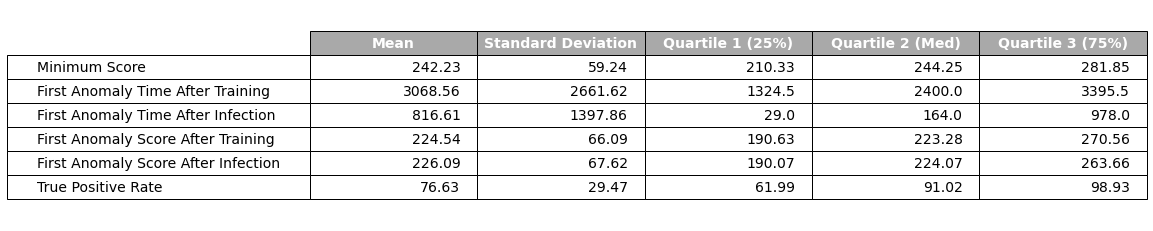

In [10]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('table_statistics_3days.png', bbox_inches='tight', facecolor='white')
